In [1]:
BASEDIR = "."

import pandas
or_data = pandas.read_csv(
    BASEDIR + '/deploy_soy_cluster.log',
    delim_whitespace=True,
)

dep_data = pandas.read_csv(
    BASEDIR + '/deploy_soy_cluster.csv',
)


In [2]:
dep_data.columns = ['workers', 'deploy_time', 'orchestration_time'] 
dep_data.head()

,workers,deploy_time,orchestration_time
0,5,1166.02,0.062379
1,10,1332.00,0.056056
2,15,1314.09,0.057854
3,20,1566.02,0.056686
4,25,1850.41,0.057393


In [3]:

or_grouped = or_data.groupby(
    ['workers']
).agg(
    {'elapsed_time':['mean','std']}
)

or_grouped.head()


elapsed_time          
                mean       std
workers                       
5           0.060359  0.014473
10          0.052850  0.016333
15          0.057029  0.016351
20          0.060745  0.012981
25          0.062591  0.013745

In [17]:
final = or_grouped.reset_index()
final.columns = ['workers', 'mean', 'std']
final['mean'] = final['mean']*100
final['std'] = final['std']*100
final.head()

,workers,mean,std
0,5,6.035924,1.447284
1,10,5.284961,1.633273
2,15,5.702943,1.635100
3,20,6.074463,1.298076
4,25,6.259094,1.374470


In [18]:
merged = dep_data
merged['orchestration_time'] = final['mean']
merged['orchestration_std'] = final['std']
# dep_data['deploy_time'] = pandas.to_timedelta(dep_data['deploy_time'], unit='s')
# merged['orchestration_time'] = pandas.to_timedelta(merged['orchestration_time'], unit='s')
# merged['orchestration_std'] = pandas.to_timedelta(merged['orchestration_std'])
final_both = merged[merged['workers'] <= 60]  # Limit to x values < 100
final_both.head()


,workers,deploy_time,orchestration_time,orchestration_std
0,5,1166.02,6.035924,1.447284
1,10,1332.00,5.284961,1.633273
2,15,1314.09,5.702943,1.635100
3,20,1566.02,6.074463,1.298076
4,25,1850.41,6.259094,1.374470


In [19]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


def create_sane_figure():
    # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    fig = plt.figure(figsize=(12, 6))  # a new figure window
    ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

    # Put the axis behind the datapoints
    ax.set_axisbelow(True)
    # Grey ticks, labels, and axis'
    for spine in ax.spines.values():
        spine.set_color('black')
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_color('black')
    ax.set_xlabel(None, fontsize=16, color='black')
    ax.set_ylabel(None, fontsize=16, color='black')
    # Don't show a grid
    ax.grid(False)
    # remove top and right border of graph
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(
        axis='both', which='both',
        labelsize=14, labelcolor='black',
        color='black')
    # Make the title big enough so it spans the entire plot, but don't make it
    # so big that it requires two lines to show.
    ax.set_title(None, fontsize=22, color='black')
    return (fig, ax)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


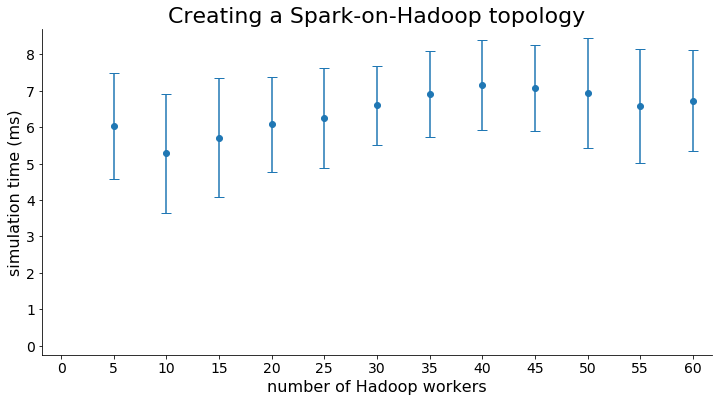

In [22]:
%matplotlib inline

def create_orchestrating_soy_cluster_graph():
    (fig, ax) = create_sane_figure()

    ax.set_title("Creating a Spark-on-Hadoop topology", fontsize=22)
    ax.set_xlabel("number of Hadoop workers")
    ax.set_ylabel("simulation time (ms)")

    ax.set_xticks(range(0, 101, 5))
    ax.set_yticks(np.arange(0, 11, 1))

    # Now put the actual data in the plot
    ax.errorbar(
        final_both['workers'], final_both['orchestration_time'],
        yerr=final_both['orchestration_std'],
        linestyle='None',
        capsize=5,
        fmt='o'
    )
    ax.plot([0], [0], color='white')  # make sure graph starts at 0
    ax.margins(0.03)
    # Save the plot to a file
    fig.savefig("orchestrating_soy_cluster.pdf", bbox_inches="tight")
    fig.show()
create_orchestrating_soy_cluster_graph()

#ff7f0e


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


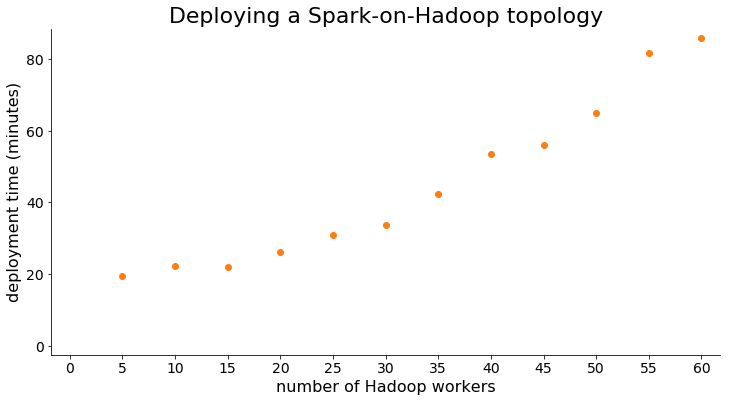

In [21]:
import matplotlib 

def create_soy_cluster_graph():
    (fig, ax) = create_sane_figure()

    ax.set_title("Deploying a Spark-on-Hadoop topology", fontsize=22)
    ax.set_xlabel("number of Hadoop workers")
    ax.set_ylabel("deployment time (minutes)")

    ax.set_xticks(range(0, 61, 5))
    ax.set_yticks(range(0, 3*60*60, 20*60))

    # Now put the actual data in the plot
#     ax.errorbar(
#         final_both['workers'], final_both['orchestration_time'],
#         yerr=final_both['orchestration_std'],
#         linestyle='None',
#         capsize=5,
#         fmt='o'
#     )
    b = ax.plot(
        final_both['workers'], final_both['deploy_time'],
        'o',     # circles instead of lines
        color="#ff7f0e",
    ) 
    
    print(matplotlib.colors.rgb2hex(b[0].get_color()))

    ax.plot([0], [0], color='white')  # make sure graph starts at 0
    ax.margins(0.03)
    from matplotlib import ticker
        
    def major_formatter(x, pos):
        #hours, remainder = divmod(x, 3600)
        #minutes, seconds = divmod(remainder, 60) 
        #duration_formatted = '%02d:%02d:%02d' % (hours, minutes, seconds)
        minutes = x/60
        duration_formatted = "{:.0f}".format(minutes)
                
        return duration_formatted
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(major_formatter))
    
    # Save the plot to a file
    fig.savefig("soy_cluster.pdf", bbox_inches="tight")
    fig.show()
    
    
create_soy_cluster_graph()

In [9]:
pandas.to_timedelta(1.00, unit='s')

Timedelta('0 days 00:00:01')